## 範例重點

* 知道如何設定監控目標
* 學習如何在 keras 中加入 Early Stopping
* 比較有無 Early Stopping 對驗證集的影響

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import backend
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


## 準備資料

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [3]:
def normalize_cifar10_data(x, y):
    x = x.reshape((len(x), -1)) / 255.
    y = np_utils.to_categorical(y, num_classes=10)
    return x, y

def normalize_result(x, y):
    print('x.shape:', x.shape)
    print('y.shape:', y.shape)

In [4]:
print('Before normalization:')
normalize_result(X_train, y_train)

Before normalization:
x.shape: (50000, 32, 32, 3)
y.shape: (50000, 1)


In [5]:
print('After normalization:')
X_train, y_train = normalize_cifar10_data(X_train, y_train)
X_test, y_test = normalize_cifar10_data(X_test, y_test)
normalize_result(X_train, y_train)

After normalization:
x.shape: (50000, 3072)
y.shape: (50000, 10)


## 定義函數

In [6]:
default_early_stopping_param = {'monitor': 'val_loss', 'patience': 5, 'verbose': 1}

def train_model(X_train, y_train, X_test, y_test, early_stopping_param, neuron_numbers=(512, 256, 128,),
                epochs=50, batch_size=256, momentum=0.95, learning_rate=1e-3):
    print('Experiment with early stopping param: {}'.format(early_stopping_param))
    backend.clear_session() # 清掉舊的 Graph
    model = build_model(X_train, X_train.shape[-1:], 10, neuron_numbers)
    model.summary()
    model.compile(optimizer=SGD(lr=learning_rate, momentum=momentum, nesterov=True),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test,),
                     callbacks=[EarlyStopping(**early_stopping_param)], shuffle=True, verbose=2)

def build_model(x, input_shape, output_units, neuron_numbers):
    main_input = hidden_input = Input(shape=input_shape, name='main_input')
    for i, neuron_number in enumerate(neuron_numbers):
        hidden_input = Dense(units=neuron_number, activation='relu', name=f'hidden_layer{i}')(hidden_input)
        hidden_input = BatchNormalization()(hidden_input)
    main_output = Dense(units=output_units, activation='softmax', name='main_output')(hidden_input)
    return Model(inputs=[main_input], outputs=[main_output])

def show_train_history(train_history, train_name, val_name):
    plt.figure(figsize=(8, 6,))
    plt.plot(train_history.history[train_name])
    plt.plot(train_history.history[val_name])
    plt.xlabel('Epoch')
    plt.ylabel(train_name)
    plt.title('Train History')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

## 訓練模型

In [7]:
## 設定超參數
early_stopping_param = {**default_early_stopping_param}

In [8]:
train_history = train_model(X_train, y_train, X_test, y_test, early_stopping_param)

Experiment with early stopping param: {'monitor': 'val_loss', 'patience': 5, 'verbose': 1}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 3072)              0         
_________________________________________________________________
hidden_layer0 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               32896     
___________________________________________________

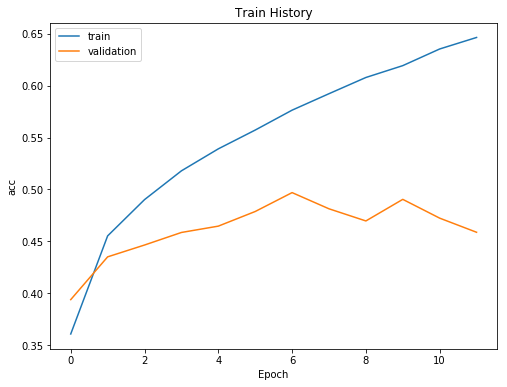

In [9]:
show_train_history(train_history, 'acc', 'val_acc')

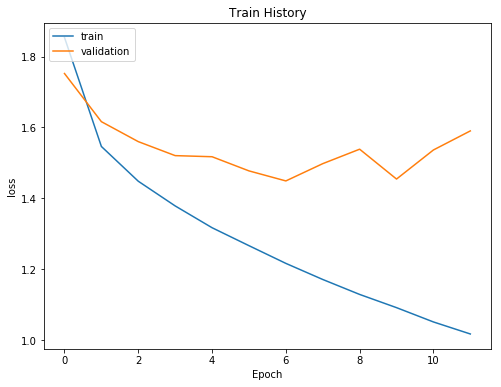

In [10]:
show_train_history(train_history, 'loss', 'val_loss')

## 作業

1. 試改變監控 Validation Accuracy 並比較結果
2. 調整 Early Stopping 的等待次數至 10 和 25 並比較結果